In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import seaborn as sns
from scipy.stats import norm

In [2]:
# 获取距离字典
distance_dict = {}
dis_matrix = []
with open('data\distance_matrix.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        dis_matrix.append([float(i) for i in row])

for row in range(1, len(dis_matrix)+1):
    for col in range(1, len(dis_matrix[0])+1):
        if row in distance_dict.keys():
            distance_dict[row][col] = dis_matrix[row-1][col-1]
        else:
            distance_dict[row] = {col: dis_matrix[row-1][col-1]}


In [3]:
# 距离依赖计算公式
def w(x, y, bandwidth):
    distance = distance_dict[x][y]
    return math.exp(-distance/bandwidth)

# 计算w分布
def wdistribution(bandwidth):
    cities = [i for i in range(1,372)]
    distribution = []
    for i in cities:
        for j in cities:
            if i != j:
                distribution.append(w(i,j,bandwidth))

    return distribution

In [25]:
# 获取lambda候选值
avg = np.average(dis_matrix)
step_length = 0.125
num = 8
start = 2
bandwidth_candidates = [i*step_length*avg for i in range(start, start+num)]
bandwidth_candidates_p = [i*step_length*avg*3 for i in range(start, start+num)]

distribution_list = []
for i in range(num):
    distribution = wdistribution(bandwidth_candidates[i])
    distribution_list.append(distribution)

distribution_list = np.array(distribution_list)

distribution_list_p = []
for i in range(num):
    distribution = wdistribution(bandwidth_candidates_p[i])
    distribution_list_p.append(distribution)

distribution_list_p = np.array(distribution_list_p)

In [27]:
fit_results = {}

# 对每个列表计算正态分布拟合
for i, data in enumerate(distribution_list):
    # 正态分布拟合，返回均值mu和标准差sigma
    mu, sigma = norm.fit(data)
    
    percentiles = [5, 10, 25, 75, 90, 95]
    percentile_values = np.percentile(data, percentiles)

    # 存储拟合参数
    fit_results[f'Group_{i+1}'] = {
        'symmetry_axis': mu
    }

    for item in range(len(percentiles)):
        fit_results[f'Group_{i+1}'][percentiles[item]] = percentile_values[item]

symmetry_axis_list = [item['symmetry_axis'] for item in fit_results.values()]
list5 = [item[5] for item in fit_results.values()]
list10 = [item[10] for item in fit_results.values()]
list25 = [item[25] for item in fit_results.values()]
list75 = [item[75] for item in fit_results.values()]
list90 = [item[90] for item in fit_results.values()]
list95 = [item[95] for item in fit_results.values()]

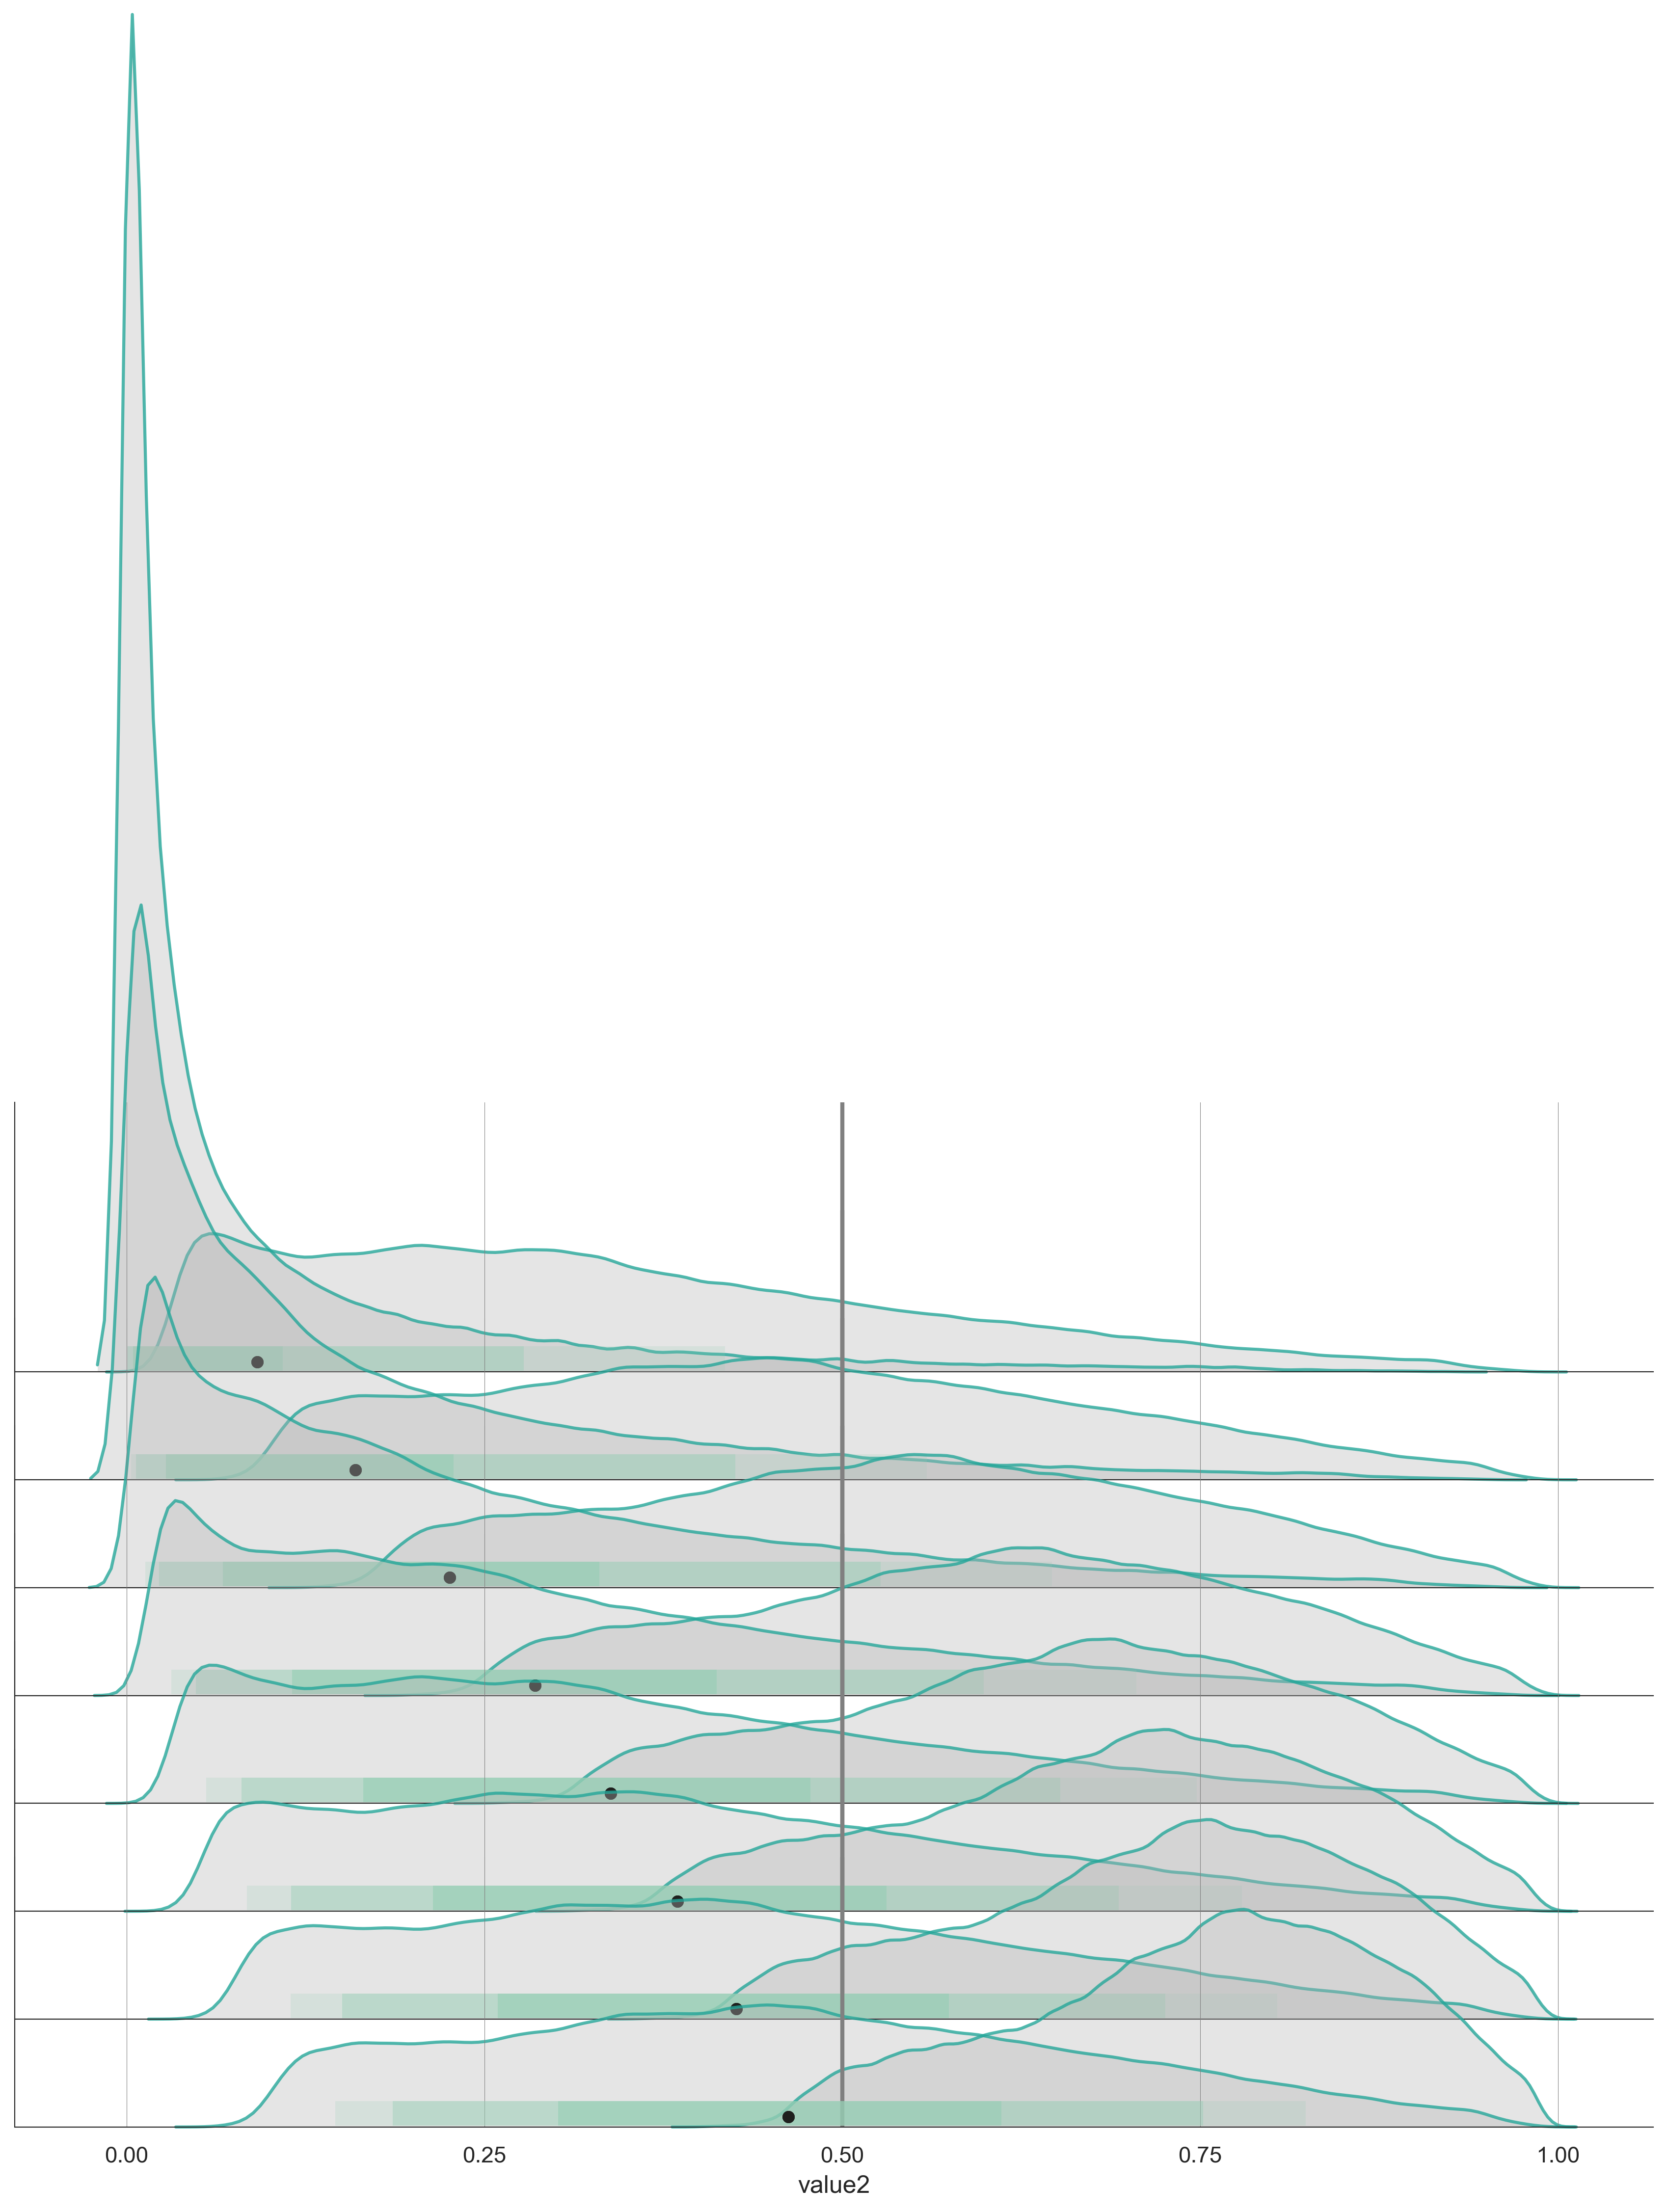

In [28]:
data = pd.DataFrame(distribution_list.T)
data = pd.melt(data, var_name='group', value_name='value')
data2 = pd.melt(pd.DataFrame(distribution_list_p.T), var_name='group', value_name='value2').drop(columns=['group'])
data = pd.concat([data, data2], axis=1)

# 设置绘图风格
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# 创建一个FacetGrid对象，这个palette的每个元素是每个密度图的填充颜色
palette = ["#B7B7B7"] * data['group'].nunique()

# 创建FacetGrid对象,aspect是每个子图的长宽比，height是每个子图的高度
g = sns.FacetGrid(data, row="group", hue="group", aspect=12, height=1, palette = palette)

# 设置图形的dpi，使得图形更清晰
g.figure.set_dpi(300)

# 绘制每个组的密度图，修改alpha使得密度图更透明
g.map(sns.kdeplot, "value", bw_adjust=.5, clip_on=False,
      fill=True, alpha=0.35, linewidth=0)
g.map(sns.kdeplot, "value2", bw_adjust=.5, clip_on=False,
      fill=True, alpha=0.35, linewidth=0)

# 边缘线，这里改密度边缘的线，主要修改color，lw（宽度），alpha
g.map(sns.kdeplot, "value", clip_on=False, color="#24a699", lw=1.5, bw_adjust=.5, alpha=0.8)
# 边缘线，这里改密度边缘的线，主要修改color，lw（宽度），alpha
g.map(sns.kdeplot, "value2", clip_on=False, color="#24a699", lw=1.5, bw_adjust=.5, alpha=0.8)

# 添加参考线
g.map(plt.axvline, x=0.5, lw=2, linestyle='-', color='gray')
g.map(plt.axvline, x=0.25, lw=0.25, linestyle='-', color='gray')
g.map(plt.axvline, x=0.75, lw=0.25, linestyle='-', color='gray')
g.map(plt.axvline, x=0, lw=0.25, linestyle='-', color='gray')
g.map(plt.axvline, x=1, lw=0.25, linestyle='-', color='gray')

# x轴粗细
g.refline(y=0, linewidth=0.5, linestyle="-", color="black", clip_on=False)

plt.rc('font', family='Times New Roman')
g.set(xticks=[0, 0.25, 0.5, 0.75, 1], yticks=[])  # 可根据需要调整刻度显示

# 移除多余的轴和样式
g.figure.subplots_adjust(hspace=-0.6)
g.set_titles("")
g.set(yticks=[], ylabel="")

for i, ax in enumerate(g.axes.flat):
    # 每个子图x=0.5的点
    ax.axvline(x=symmetry_axis_list[i], color='#1E201E', linestyle='-', linewidth=2.5, ymax=0.0375, ymin = 0.0375, zorder=99, marker= 'o',markersize=5)

    # 下面三个是每个子图水平的代表90%-80%-50%区间的方块，修改color和alpha，注意其是堆叠的
    ax.hlines(y=0.2, xmin=list5[i], xmax=list95[i], color='#96CEB4', linestyle='-', linewidth=12, alpha=0.2)
    ax.hlines(y=0.2, xmin=list10[i], xmax=list90[i], color='#96CEB4', linestyle='-', linewidth=12, alpha=0.4)
    ax.hlines(y=0.2, xmin=list25[i], xmax=list75[i], color='#96CEB4', linestyle='-', linewidth=12, alpha=0.6)

    ax.spines['left'].set_linewidth(0.5)   # 设置 y 轴的粗细
    ax.spines['bottom'].set_linewidth(0.5)  # 设置 x 轴的粗细

    # 设置y轴范围，越小的话。密度图越凸
    ax.set_ylim(0, 4)


# 显示图像
plt.show()

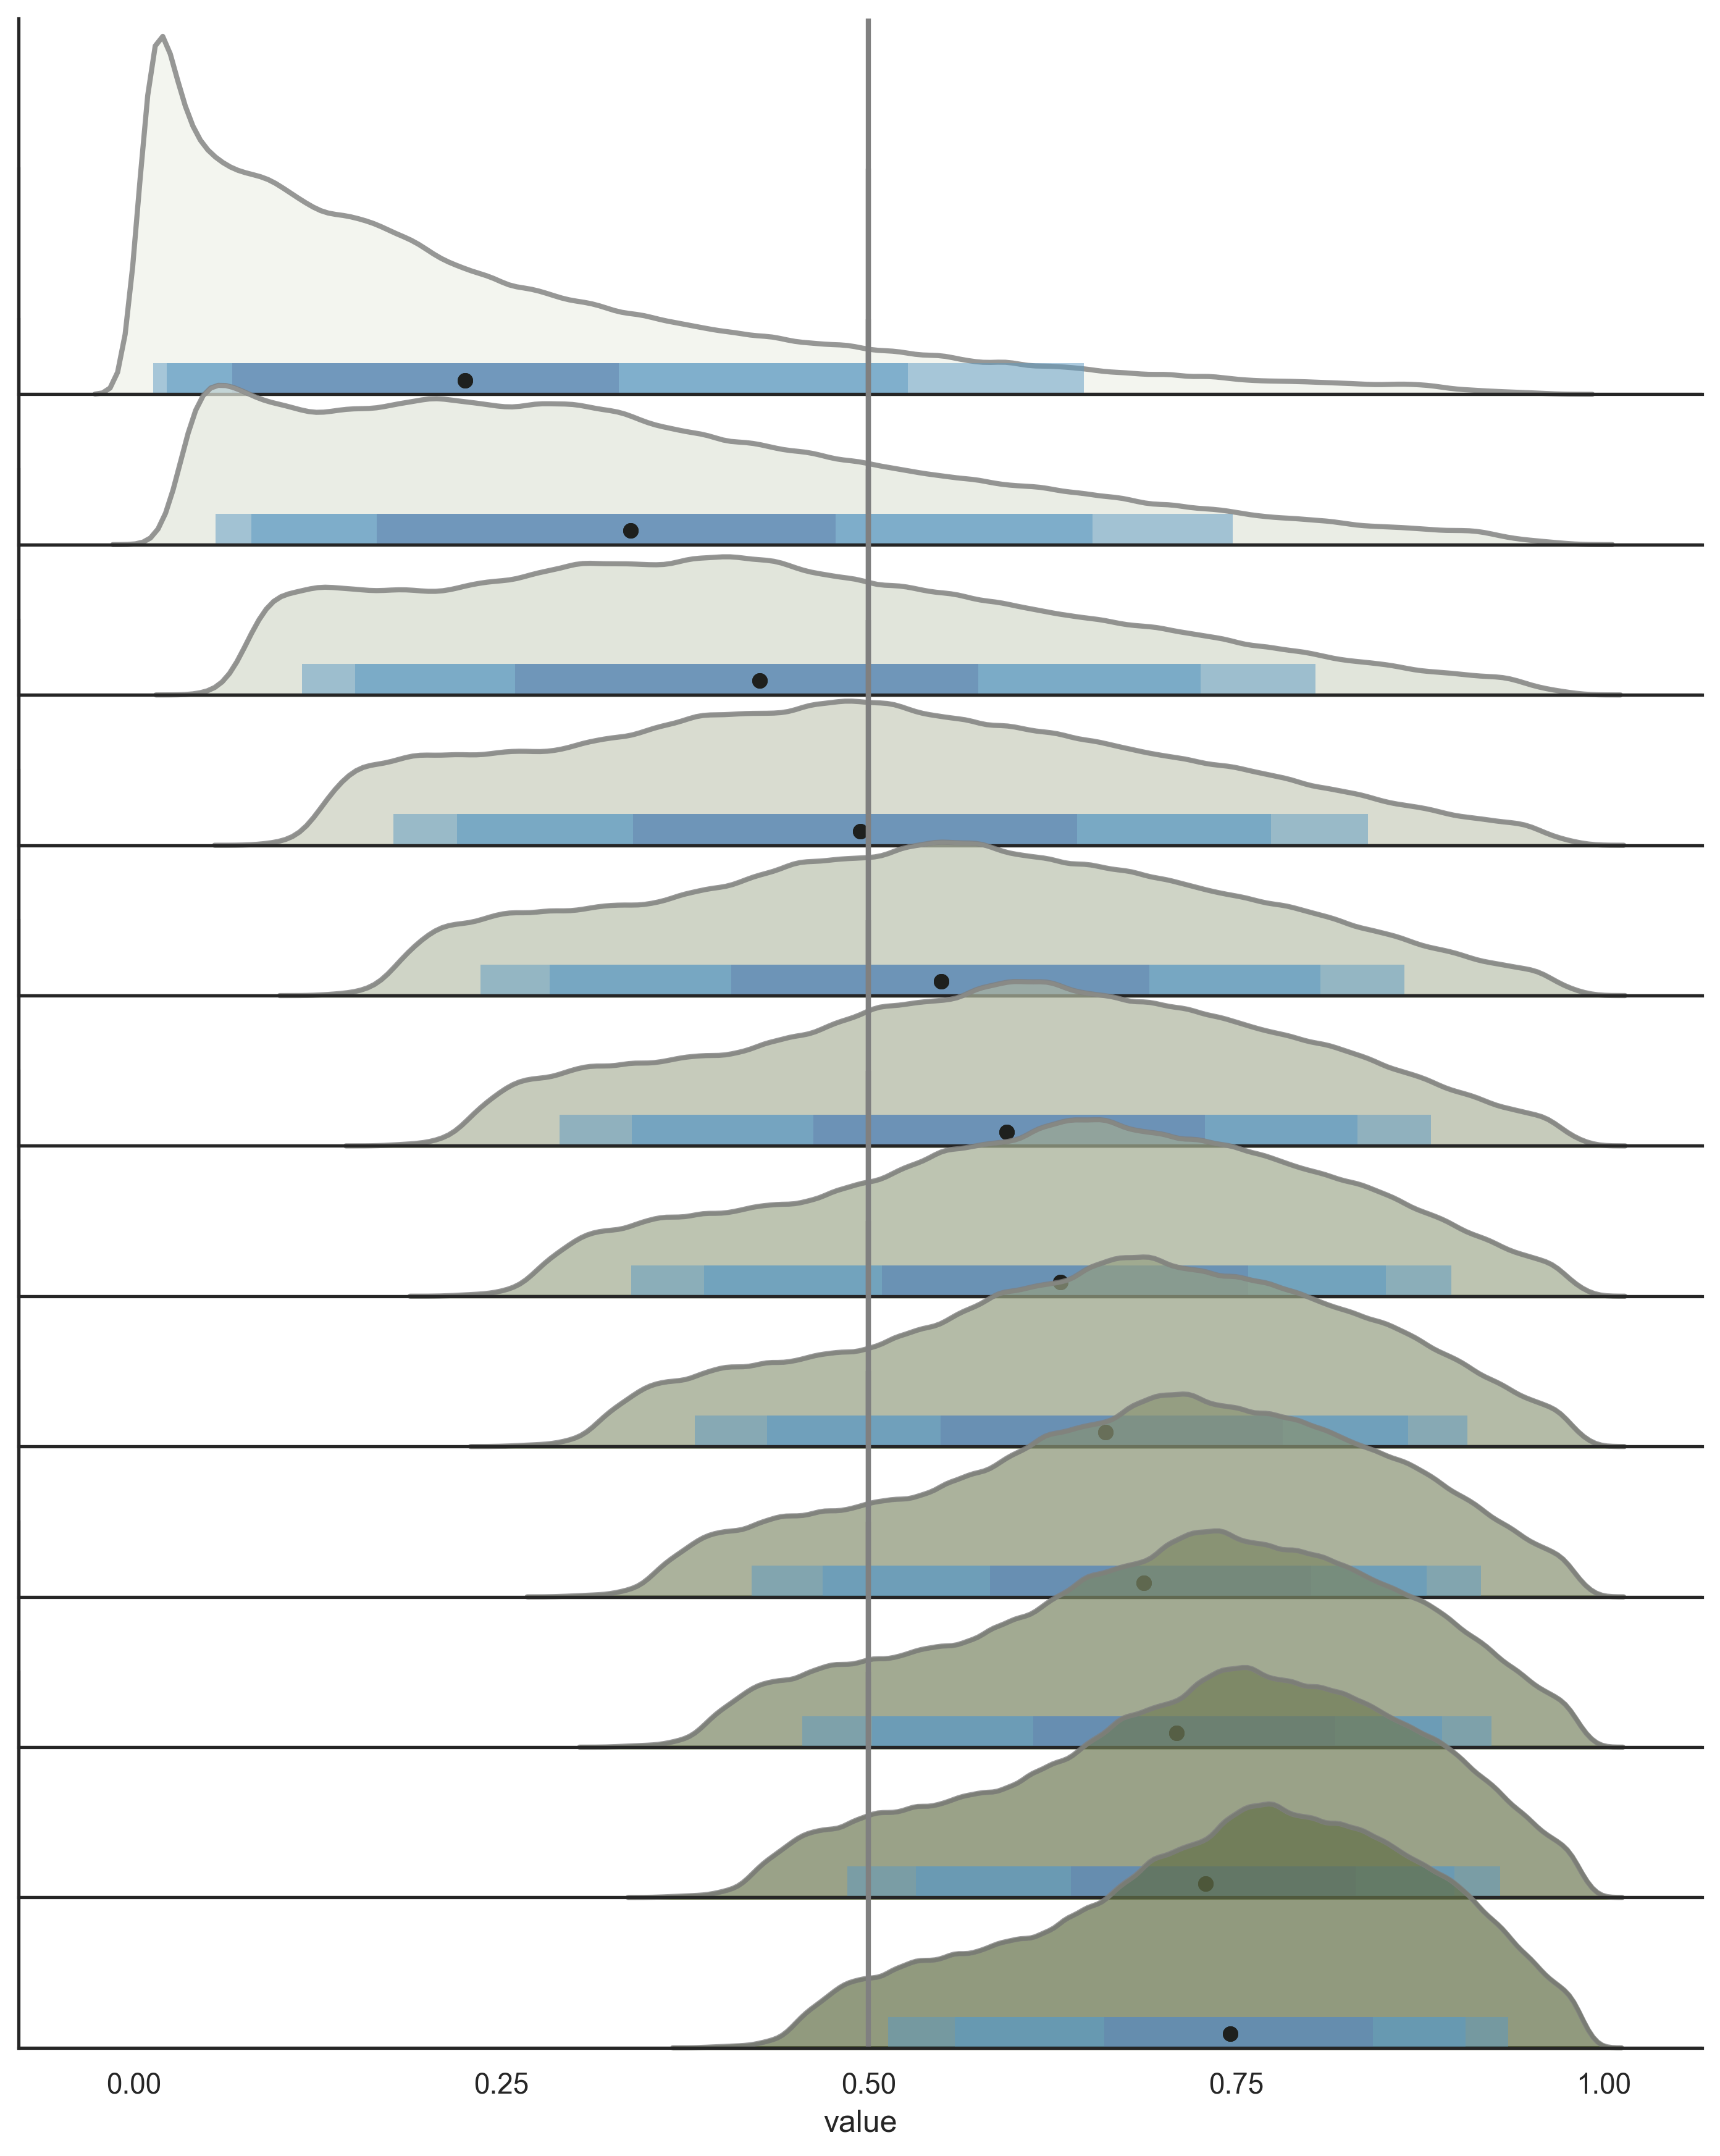

In [55]:
data = pd.DataFrame(distribution_list.T)
data = pd.melt(data, var_name='group', value_name='value')

# 设置绘图风格
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# 创建一个FacetGrid对象
palette = sns.light_palette("#626F47", n_colors=data['group'].nunique(), reverse=False, input="hex", as_cmap=False)
g = sns.FacetGrid(data, row="group", hue="group", aspect=10, height=1, palette=palette)
g.figure.set_dpi(300)

# 绘制每个组的密度图
g.map(sns.kdeplot, "value", bw_adjust=.5, clip_on=False,
      fill=True, alpha=0.7, linewidth=1.5)

# 边缘线
g.map(sns.kdeplot, "value", clip_on=False, color="gray", lw=2, bw_adjust=.5, alpha=0.8)

# 添加参考线
g.map(plt.axvline, x=0.5, lw=2, linestyle='-', color='gray')

# x轴设为2
g.refline(y=0, linewidth=1, linestyle="-", color="black", clip_on=False)

plt.rc('font', family='Times New Roman')
g.set(xticks=[0, 0.25, 0.5, 0.75, 1], yticks=[])  # 可根据需要调整刻度显示

# 移除多余的轴和样式
g.figure.subplots_adjust(hspace=-0.6)
g.set_titles("")
g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)

for i, ax in enumerate(g.axes.flat):
    ax.axvline(x=symmetry_axis_list[i], color='#1E201E', linestyle='-', linewidth=2.5, ymax=0.0375, ymin = 0.0375, zorder=99, marker= 'o',markersize=5)
    ax.hlines(y=0.2, xmin=list5[i], xmax=list95[i], color='#5B99C2', linestyle='-', linewidth=12, alpha=0.5)
    ax.hlines(y=0.2, xmin=list10[i], xmax=list90[i], color='#5B99C2', linestyle='-', linewidth=12, alpha=0.5)
    ax.hlines(y=0.2, xmin=list25[i], xmax=list75[i], color='#6482AD', linestyle='-', linewidth=12, alpha=0.5)


# 显示图像
plt.show()